In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.mplot3d
import mpl_toolkits.axes_grid1 as plt_ax
import scipy.stats
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold
%matplotlib inline


In [3]:
training_ridge = np.loadtxt('TrainingRidge.csv', skiprows=1, dtype=bytes, delimiter=',').astype(np.float64)
validation_ridge = np.loadtxt('ValidationRidge.csv', skiprows=1, dtype=bytes, delimiter=',').astype(np.float64)
validation_set = validation_ridge[:, 2].reshape(41, 36).T

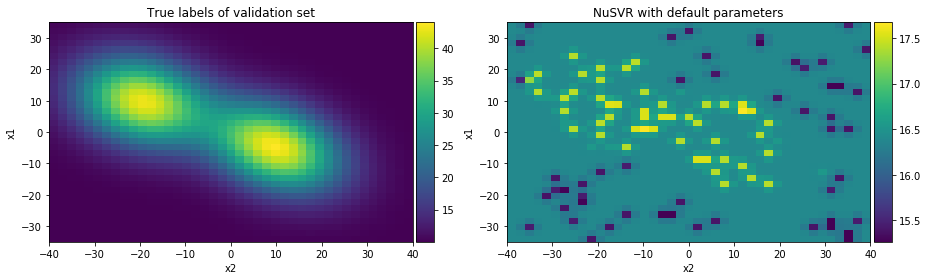

In [4]:
# 2.a)
svr_a = svm.NuSVR()
svr_a.fit(training_ridge[:, :2], training_ridge[:, 2])
preds_a = svr_a.predict(validation_ridge[:, :2]).reshape(41, 36).T

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

img = ax[0].imshow(validation_set, extent=[-40, 40, -35, 35], aspect='auto')
cax = plt_ax.make_axes_locatable(ax[0]).append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(img, cax=cax)
ax[0].set_ylabel('x1')
ax[0].set_xlabel('x2')
ax[0].set_title('True labels of validation set')

img = ax[1].imshow(preds_a, extent=[-40, 40, -35, 35], aspect='auto')
cax = plt_ax.make_axes_locatable(ax[1]).append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(img, cax=cax)
ax[1].set_ylabel('x1')
ax[1].set_xlabel('x2')
ax[1].set_title('NuSVR with default parameters')
fig.tight_layout()

In [5]:
# 2.b: 10-fold cross validation
X = training_ridge[:, :2]
Y = training_ridge[:, 2]
C = np.power(2.0, np.arange(-2, 13))
Gamma = np.power(2.0, np.arange(-12, 1))
results = []
kf = KFold(n_splits=10)
for c in C:
    c_results = []
    for g in Gamma:
        scores = []
        for train_i, test_i in kf.split(X):
            svr_b = svm.NuSVR(kernel='rbf', nu=0.5, C=c, gamma=g)
            svr_b.fit(X[train_i], Y[train_i])
            preds_b = svr_b.predict(X[test_i, :])
            scores.append(metrics.mean_squared_error(preds_b, Y[test_i]))
        c_results.append(np.mean(scores))
    results.append(c_results)

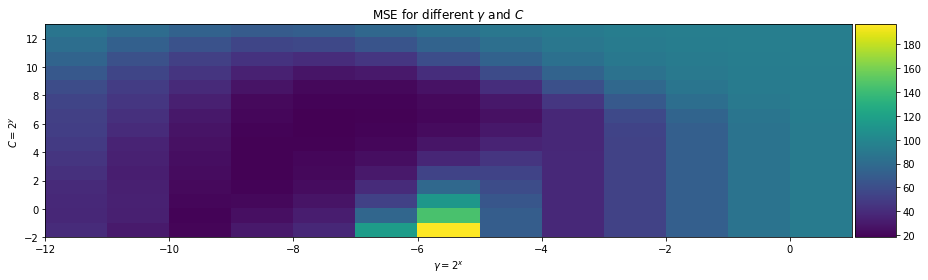

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(13, 4))
img = ax.imshow(results, extent=[-12, 1, -2, 13], aspect='auto')
cax = plt_ax.make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(img, cax=cax)
ax.set_ylabel(r'$C = 2^y$')
ax.set_xlabel(r'$\gamma = 2^x$')
ax.set_title(r'MSE for different $\gamma$ and $C$')
fig.tight_layout()

In [7]:
tuned_parameters = {'C': np.power(2.0, np.arange(-2, 13)),'gamma': np.power(2.0, np.arange(-12, 1))}
svr_c = GridSearchCV(svm.NuSVR(kernel='rbf', nu=0.5), tuned_parameters, cv=10, scoring='neg_mean_squared_error')
svr_c.fit(training_ridge[:, :2], training_ridge[:, 2])
best_params = svr_c.best_params_

print('Best parameters for v-SVR: C={:4.4f} and gamma={:4.4f}'.format(best_params['C'], best_params['gamma']))
print('Best cross validation scores {:4.4f}'.format(-svr_c.best_score_))

best_preds = svr_c.best_estimator_.predict(validation_ridge[:, :2]).reshape(41, 36).T

Best parameters for v-SVR: C=16.0000 and gamma=0.0039
Best cross validation scores 18.0978


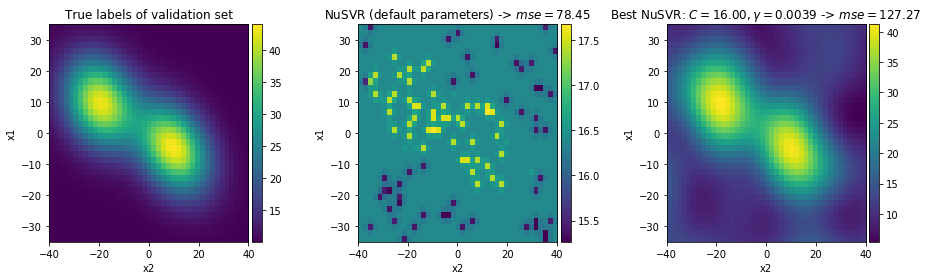

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

img = ax[0].imshow(validation_set, extent=[-40, 40, -35, 35], aspect='auto')
cax = plt_ax.make_axes_locatable(ax[0]).append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(img, cax=cax)
ax[0].set_ylabel('x1')
ax[0].set_xlabel('x2')
ax[0].set_title('True labels of validation set')

img = ax[1].imshow(preds_a, extent=[-40, 40, -35, 35], aspect='auto')
cax = plt_ax.make_axes_locatable(ax[1]).append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(img, cax=cax)
ax[1].set_ylabel('x1')
ax[1].set_xlabel('x2')
ax[1].set_title(r'NuSVR (default parameters) -> $mse = {:4.2f}$'.format(
    metrics.mean_squared_error(preds_a.flatten(), validation_ridge[:, 2])))

img = ax[2].imshow(best_preds, extent=[-40, 40, -35, 35], aspect='auto')
cax = plt_ax.make_axes_locatable(ax[2]).append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(img, cax=cax)
ax[2].set_ylabel('x1')
ax[2].set_xlabel('x2')
ax[2].set_title(r'Best NuSVR: $C = {:4.2f} , \gamma = {:4.4f}$ -> $mse = {:4.2f}$'.format(
    best_params['C'], best_params['gamma'], metrics.mean_squared_error(best_preds.flatten(), validation_ridge[:, 2])))
fig.tight_layout()

In [9]:
print('Best parameters for v-SVR: C={:4.4f} and gamma={:4.4f}'.format(best_params['C'], best_params['gamma']))
print('Best cross validation scores {:4.4f}'.format(-svr_c.best_score_))

Best parameters for v-SVR: C=16.0000 and gamma=0.0039
Best cross validation scores 18.0978
